https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [8]:
import csv
import cv2
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [9]:
# Load the CSV
# https://blog.finxter.com/convert-csv-to-list-of-tuples-in-python/
 
dataset_path_training = 'training.csv'
dataset_path_test = 'test.csv'

image_size=(64,64,3) #add 3 if RGB image

data_training = pd.read_csv(dataset_path_training)
data_test = pd.read_csv(dataset_path_test)
 
def load_from_csv(data):
    
    pixels1 = data['Pixels1'].tolist()
    pixels2 = data['Pixels2'].tolist()
    pixels3 = data['Pixels3'].tolist()
    
    pixels = []
    
    for pixel1, pixel2, pixel3 in zip(pixels1, pixels2, pixels3):
        # Assuming pixel1 and pixel2 are space-separated strings of pixel values
        concatenated_pixel = pixel1 + ' ' + pixel2 + ' ' + pixel3
        pixels.append(concatenated_pixel)
    
    width, height, depth= 64, 64 ,3 # add depth 3 if RGB image
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height, depth) #add depth if RGB image
        a = face
        face = np.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    return faces

# load train and test data from csv file 

def load_dataset(): 
    
    trainX = load_from_csv(data_training)
    trainY = np.array(data_training['Labels'].tolist())
    
    testX = load_from_csv(data_test)
    testY = np.array(data_test['Labels'].tolist())
    
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY

In [10]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float64')
    test_norm = test.astype('float64')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [11]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(64, 64, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    print(" ")
    
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.show()
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()
    
# The blue lines will indicate model performance on the training dataset and 
# orange lines will indicate performance on the hold out test dataset. 

In [13]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # define model
    model = define_model()
    # fit model
    history = model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY), verbose=0)
    # save model
    model.save('layerone_model_v2.h5')
    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))
    return history

This test harness can evaluate any CNN models we may wish to evaluate on the CIFAR-10 dataset and can run on the CPU or GPU.

Note: as is, no model is defined, so this complete example cannot be run.

Define and evaluate a baseline model below: 

C:\Users\littl\anaconda3\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


> 93.562
 


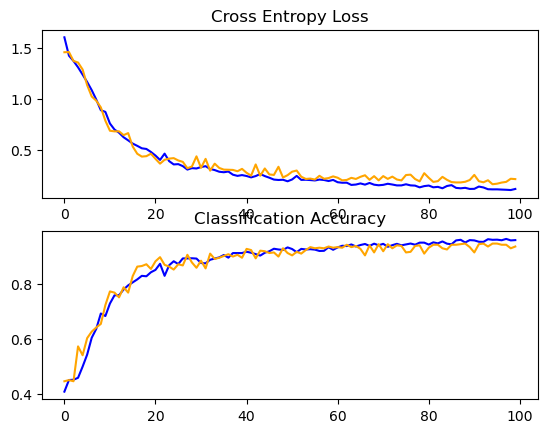

In [14]:
# entry point, run the test harness
history = run_test_harness()
summarize_diagnostics(history)